In [21]:
# Import des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd
import sys
import os
from osgeo import gdal, gdal_array
from shapely.geometry import Point
import seaborn as sns
# Ajout du chemin vers les fonctions personnalisées
sys.path.append('/home/onyxia/work/Depot_Git/scripts')
from my_function import main, get_samples_from_roi, calcul_distance
sys.path.append('/home/onyxia/work/libsigma')
import classification as cla

In [22]:
# Définition des paramètres 
my_folder = '/home/onyxia/work/results/data'
in_vector = os.path.join(my_folder, 'sample/Sample_BD_foret_T31TCJ.shp')
raster_name = os.path.join(my_folder, 'img_pretraitees/Serie_temp_S2_allbands.tif')
out_image = os.path.splitext(in_vector)[0] + '_v2.tif'
field_name = 'Code'  # field containing the numeric label of the classes

In [23]:
# for those parameters, you know how to get theses information if you had to
sptial_resolution = 10
xmin = 501127.9696999999
ymin = 6240654.023599998
xmax = 609757.9696999999
ymax = 6314464.023599998

In [24]:
# Lecture du shp
in_vector = os.path.join(my_folder, 'sample/Sample_BD_foret_T31TCJ.shp')
gdf = gpd.read_file(in_vector)

# Création d'un dictionnaire pour assigner une valeur d'ID
unique_ids = gdf['ID'].unique()
id_to_int = {id_: idx for idx, id_ in enumerate(unique_ids)}
int_to_id = {v: k for k, v in id_to_int.items()}

# Ajout ID au shp
gdf['ID_num'] = gdf['ID'].map(id_to_int)

# Save du shp temporaire
temp_vector = os.path.splitext(in_vector)[0] + '_temp.shp'
gdf.to_file(temp_vector)

# Champs a rasteriser
field_class = 'Code'  # Classe
field_id = 'ID_num'  # ID des polygones

# Définitions des noms pour la sauvegarde
out_image_class = os.path.splitext(in_vector)[0] + '_class.tif'
out_image_id = os.path.splitext(in_vector)[0] + '_id.tif'

# Rasterisation des classes
cmd_class = (
    "gdal_rasterize -a {field_class} "
    "-tr {sptial_resolution} {sptial_resolution} "
    "-te {xmin} {ymin} {xmax} {ymax} -ot Byte -of GTiff "
    "{in_vector} {out_image_class}"
).format(
    in_vector=in_vector, field_class=field_class, sptial_resolution=sptial_resolution,
    xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, out_image_class=out_image_class
)

# Rasterisation des ID
cmd_id = (
    "gdal_rasterize -a {field_id} "
    "-tr {sptial_resolution} {sptial_resolution} "
    "-te {xmin} {ymin} {xmax} {ymax} -ot Int32 -of GTiff "
    "{temp_vector} {out_image_id}"
).format(
    temp_vector=temp_vector, field_id=field_id, sptial_resolution=sptial_resolution,
    xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, out_image_id=out_image_id
)

# Execution des codes
os.system(cmd_class)
os.system(cmd_id)

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


0

In [25]:
image_filename = os.path.join(my_folder, 'img_pretraitees/Serie_temp_S2_allbands.tif')
sample_filename = os.path.join(my_folder, 'sample/Sample_BD_foret_T31TCJ_class.tif')
id_image_filename = os.path.join(my_folder, 'sample/Sample_BD_foret_T31TCJ_id.tif')
gdf_filtered = main(in_vector, image_filename, sample_filename, id_image_filename)
print(gdf_filtered.head())

          geometry  class  polygon_id  band_1  band_2  band_3  band_4  band_5  \
0  POINT (8124 77)     12       11038    1913    1105     553     822     926   
1  POINT (8124 78)     12       11038    1399     799     518     755     759   
2  POINT (8125 78)     12       11038    1399     799     401     597     569   
3  POINT (8124 79)     12       11038    1399     799     263     346     362   
4  POINT (8125 79)     12       11038    1399     799     210     343     293   

   band_6  band_7  ...  band_59  band_60  index_right   ID  CODE_TFV  TFV  \
0    1293    2168  ...     3029     3378          NaN  NaN       NaN  NaN   
1     838    1549  ...     2140     1781          NaN  NaN       NaN  NaN   
2     838    1549  ...     2710     1781          NaN  NaN       NaN  NaN   
3     838    1549  ...      870     1781          NaN  NaN       NaN  NaN   
4     838    1549  ...     1183     1781          NaN  NaN       NaN  NaN   

   TFV_G11  ESSENCE  Nom  Code  
0      NaN      N

In [26]:
band_columns = [f'band_{i}' for i in range(1, 61)]
# Calcul du centroïde spectral
centroide_spectral = gdf_filtered.groupby(['class', 'polygon_id'])[band_columns].mean().reset_index()

# Montre les résultats
print(centroide_spectral.head())

# Merge entre gdf_filtré et les centroides
gdf_merged = gdf_filtered.merge(centroide_spectral, on=['class', 'polygon_id'], suffixes=('', '_centroid'))

   class  polygon_id       band_1       band_2      band_3      band_4  \
0     11          78  1633.150725   930.695652  242.495652  336.939130   
1     11          94  1302.926531   822.318367  250.930612  385.391837   
2     11          99  1396.871176   850.895330  251.040258  394.948470   
3     11         204  2109.803526  1257.725441  358.259446  501.171285   
4     11         205  1980.496269  1119.235075  314.003731  448.227612   

       band_5      band_6       band_7       band_8  ...      band_51  \
0  466.333333  719.342029  1106.797101  1316.762319  ...  1710.353623   
1  439.269388  696.257143  1040.224490  1169.840816  ...  1437.755102   
2  443.104670  726.515298  1153.040258  1317.392915  ...  1540.198068   
3  638.123426  952.433249  1434.710327  1642.370277  ...  1725.833753   
4  544.123134  888.820896  1442.511194  1667.145522  ...  1843.347015   

      band_52     band_53     band_54     band_55      band_56      band_57  \
0  753.063768  225.820290  471.144928

In [28]:
band_columns = [f'band_{i}' for i in range(1, 61)]
# Distance entre chaque bande et son centroide
for band in band_columns:
    gdf_merged[f'diference_{band}'] = gdf_merged[band] - gdf_merged[f'{band}_centroid']

# Reset de l'indice
gdf_merged = gdf_merged.reset_index(drop=True)

# Groupe par classe et id de polygon
gdf_merged = gdf_merged.groupby(['class', 'polygon_id'], as_index=False).apply(lambda group: calcul_distance(group, band_columns))

# Calcule la distance moyenne par classe et polygon_id
# distancia_promedio = gdf_merged.groupby(['class', 'polygon_id'])["distance_euclidienne"].mean()
distance_moyenne = gdf_merged.groupby(['class', 'polygon_id'])["distance_euclidienne"].mean()
# Mostrar el resultado
print(distance_moyenne)


/tmp/ipykernel_178688/3389089782.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gdf_merged = gdf_merged.groupby(['class', 'polygon_id'], as_index=False).apply(lambda group: calcul_distance(group, band_columns))


class  polygon_id
11     78            1732.804795
       94            1843.561564
       99            2242.930016
       204           2699.502970
       205           1885.465186
                        ...     
29     10850         2080.250016
       10961         1867.872538
       10997         1304.576879
       11004         1053.491625
       11037         2060.795332
Name: distance_euclidienne, Length: 5643, dtype: float64


### Calcul de distance moyenne par rapport  au centroide de la classe à l'échelle de l'image

/tmp/ipykernel_178688/724898389.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='class', y='distance_euclidienne', data=distance_moyenne_par_classe, palette=palette)


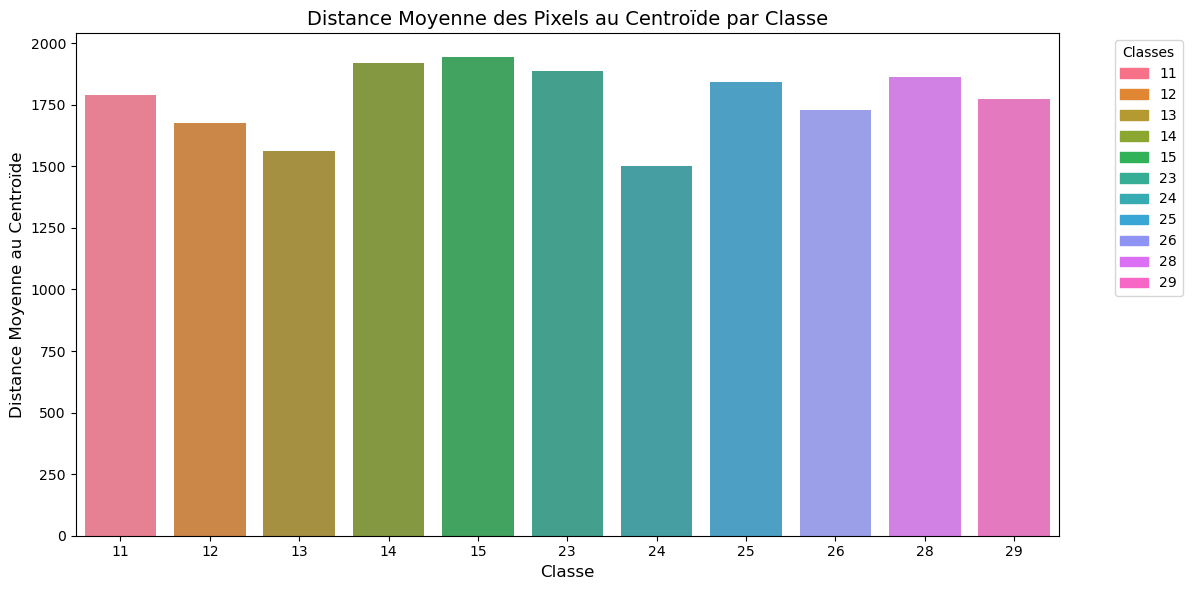

In [29]:
# Calcul de la distance moyenne au centroïde par classe
distance_moyenne_par_classe = gdf_merged.groupby('class')['distance_euclidienne'].mean().reset_index()

# Définir une palette de couleurs pour chaque classe
palette = sns.color_palette("husl", len(distance_moyenne_par_classe))

# Création du bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='class', y='distance_euclidienne', data=distance_moyenne_par_classe, palette=palette)

# Ajout des étiquettes et du titre
plt.xlabel('Classe', fontsize=12)
plt.ylabel('Distance Moyenne au Centroïde', fontsize=12)
plt.title('Distance Moyenne des Pixels au Centroïde par Classe', fontsize=14)

# Création de la légende
handles = [plt.Rectangle((0,0),1,1, color=palette[i]) for i in range(len(distance_moyenne_par_classe))]
labels = distance_moyenne_par_classe['class'].astype(str).tolist()
plt.legend(handles, labels, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Affichage du graphique
plt.tight_layout()
plt.show()


### Calcul de distance moyenne par rapport au centroide de polygone par classe 

/tmp/ipykernel_178688/3175340780.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='class', y='distance_euclidienne', data=distance_moyenne_df, inner='quart', palette="Set2")


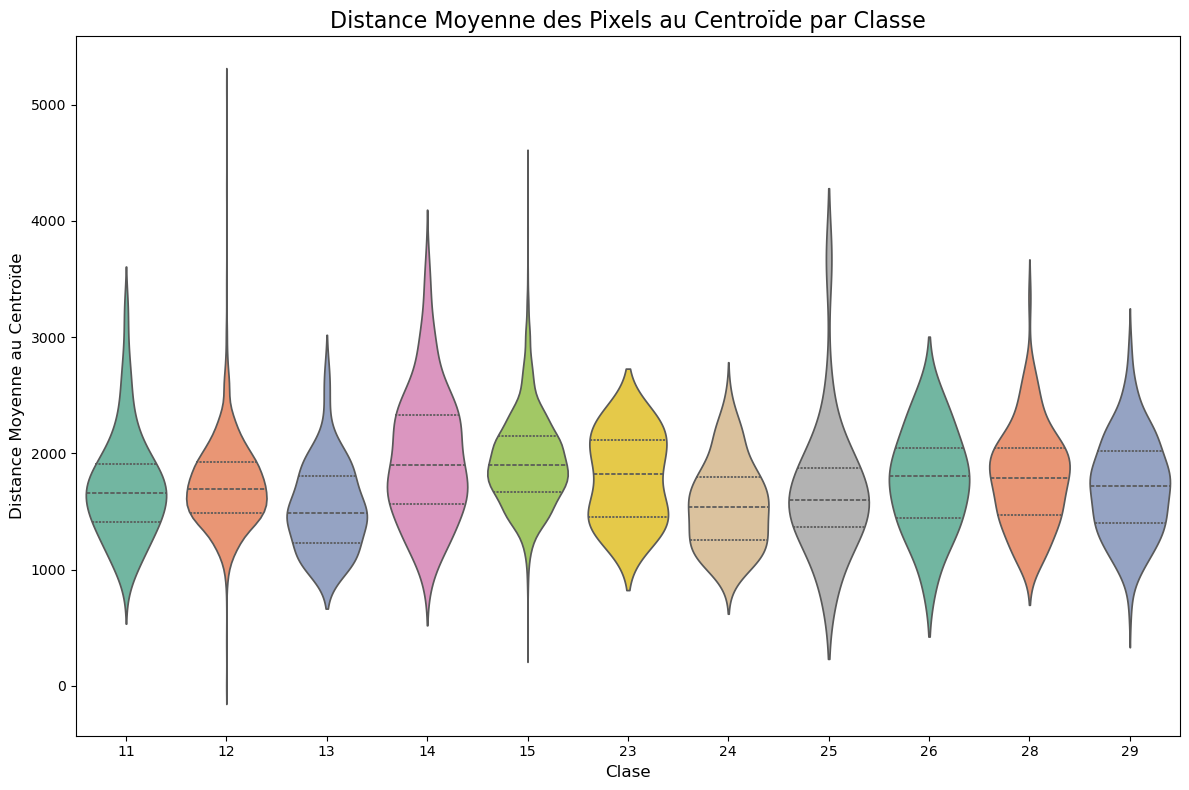

In [31]:
# Conversion du resultat de distance moyenne en dataframe
distance_moyenne_df = distance_moyenne.reset_index()

# Création d'un graphe violin_plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='class', y='distance_euclidienne', data=distance_moyenne_df, inner='quart', palette="Set2")

# Modification des titres et étiquettes
plt.title('Distance Moyenne des Pixels au Centroïde par Classe', fontsize=16)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Distance Moyenne au Centroïde', fontsize=12)

# Plot du graphe
plt.tight_layout()
plt.show()
